In [ ]:
import numpy as np # For computations of probabilities, perplexities and expected count
import pandas as pd # For transforming JSON data into a pandas dataframe
import nltk # Used for tokenization of training and testing set
from nltk import pos_tag # Used for parts of speech (POS) tagging
from tqdm import tqdm # For displaying progress bar
from sklearn.preprocessing import OneHotEncoder # Used for converting extracted features to vectors
from sklearn.model_selection import train_test_split # Used to split training and testing set
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from typing import Iterator
from collections import Counter
from nltk import ngrams
import ollama

In [ ]:
# B.1.1: Define the maximum length for a sequence
MAX_LEN = 40


# B.1.4: CSV path
csv_path = (r'C:\Users\Jeryl Salas\OneDrive\Documents\AI Work\TaskEstimator\CLEANED_ONE_HOT_developers_estimation_data_july_24_hour_09.csv')

# B.1.5: Load the dataset from CSV
df = pd.read_csv(csv_path)


In [ ]:
# Convert one hot encoding to just one column (Wasn't able to use in this instance)
start_col_idx = 10
job_position_columns = df.columns[start_col_idx:]
processed_columns = job_position_columns.str.replace('Job Position: ', '')
df.rename(columns=dict(zip(job_position_columns, processed_columns)), inplace=True)
def get_job_position(row):
    return row.idxmax()
df['Job Position'] = df.iloc[:, start_col_idx:].apply(get_job_position, axis=1)
pd.set_option('display.max_columns', None)
print(df[:10])


# Display train and test num rows
print(f'No. of rows: {len(df)}')

                                           task_name  task_actual_hours  \
0  Automation | Time/Money: Timelogs | Viewing of...              12.23   
1  OPF: Org/Workforce Executive - Memorandums: No...               0.77   
2  OPF: Org Executive: Breach of Contract Amount ...               0.00   
3  OPF: Issues-Card: Unable to create a card if n...               1.35   
4  OPF: Issues - Card Creation Modal - All Member...               0.00   
5  OPF: Log out: Infinite loading when logging ou...               1.46   
6  OPF: Requests: Rejecting a request: CapsLock w...               0.00   
7  OPF: Org Exec/Manager/Supervisor - Tags: Add E...               9.54   
8      OPF: Employment - 201 Files: Cannot Upload ID               0.00   
9        [ScalemaAI] - FE - Chat Feed Implementation              27.80   

   estimation_hours                employee_name  years_of_experience  \
0             12.00                Lydia Karungi                    3   
1             16.00  Osho Ga

In [ ]:
# Frequency distribution of 'task_actual_hours'
frequency_distribution = df['task_actual_hours'].value_counts().sort_index()

# Display the result
print(frequency_distribution)

task_actual_hours
0.00      188
0.00        1
0.00        1
0.00        1
0.08        1
         ... 
92.58       1
93.17       1
95.73       1
296.96      1
373.82      1
Name: count, Length: 4142, dtype: int64


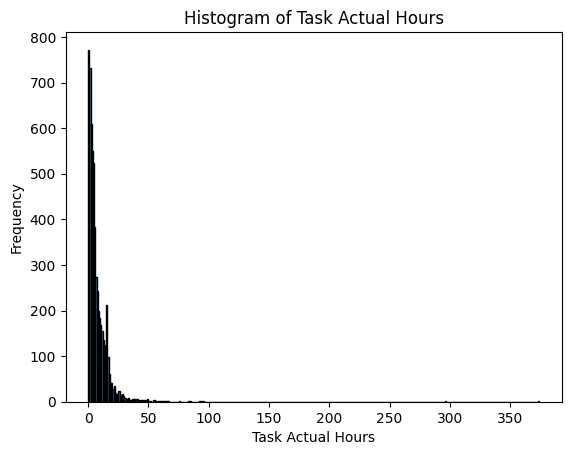

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of 'task_actual_hours' from 0 to the maximum value
plt.hist(df['task_actual_hours'], bins=range(0, int(df['task_actual_hours'].max()) + 2), edgecolor='black')

# Add labels and title
plt.xlabel('Task Actual Hours')
plt.ylabel('Frequency')
plt.title('Histogram of Task Actual Hours')

# Show the plot
plt.show()

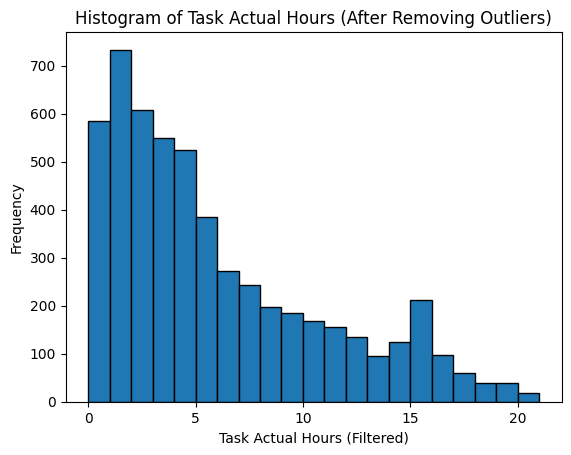

In [ ]:
# Remove values greater than the 95th percentile
upper_limit = df['task_actual_hours'].quantile(0.95)
df_filtered = df[(df['task_actual_hours'] <= upper_limit) & (df['task_actual_hours'] > 0)]

# Plot the histogram after filtering out outliers
plt.hist(df_filtered['task_actual_hours'], bins=range(0, int(df_filtered['task_actual_hours'].max()) + 2), edgecolor='black')

# Add labels and title
plt.xlabel('Task Actual Hours (Filtered)')
plt.ylabel('Frequency')
plt.title('Histogram of Task Actual Hours (After Removing Outliers)')

# Show the plot
plt.show()


In [ ]:
# Number of rows before and after filtering
original_count = len(df)
filtered_count = len(df_filtered)

# Calculate how many were filtered out
filtered_out_count = original_count - filtered_count

# Display the result
print(f"Original count: {original_count}")
print(f"Filtered count: {filtered_count}")
print(f"Number of rows filtered out: {filtered_out_count}")

Original count: 5911
Filtered count: 5427
Number of rows filtered out: 484


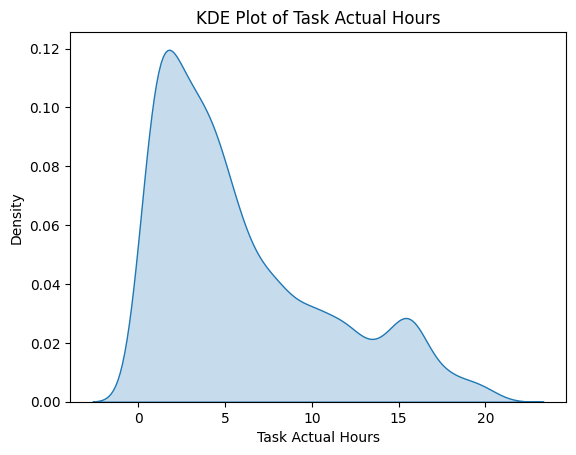

In [ ]:
import seaborn as sns

# Plot KDE for task_actual_hours
sns.kdeplot(df_filtered['task_actual_hours'], fill=True)

# Add labels and title
plt.xlabel('Task Actual Hours')
plt.ylabel('Density')
plt.title('KDE Plot of Task Actual Hours')

# Show the plot
plt.show()


In [ ]:
df = df_filtered

In [ ]:
def replace_characters(text: str) -> str:
    """
    Replaces specific special characters in the input text according to predefined replacement rules.
    """
    replacement_rules = {'“': '', '”': '', '’': "", '--': '', '(' : '', ')' : '', ',' : '', ';': '', '-': '', '_': '', '-': '', '|': '', ':': '', '/': ' ', '[': '', ']': ''}
    for symbol, replacement in replacement_rules.items():
        text = text.replace(symbol, replacement)
    return text

def generate_tokens(paragraph: str) -> Iterator[str]:
    """
    Tokenize sentences using RegexpTokenizer and appending '[END]' token on each setence
    """
    word_tokenizer = RegexpTokenizer(r'\b\w+\b')

    for sentence in sent_tokenize(paragraph):
        tokenized_sentence = word_tokenizer.tokenize(sentence)
        if tokenized_sentence:
            yield tokenized_sentence


def preprocess(set):
    """
    Main preprocessing function used to load and process text data and output tokens for both training and testing.
    The number of input entries should equal the number of tokenized sentences output, with multiple sentences merged.
    """

    tokenized_sentences = []
    i = 0
    print("Total items in set:", len(set))  # Print number of items in the input set

    for id, text in set.items():
        cleaned_text = replace_characters(text.lower())

        # Generate tokens for each entry and merge sentences if needed
        tokenized_sentences_for_entry = list(generate_tokens(cleaned_text))  # Convert to list to check length

        # Merge all tokenized sentences into one sentence per entry
        merged_sentence = []
        for sentence in tokenized_sentences_for_entry:
            merged_sentence.extend(sentence)  # Merge tokens from multiple sentences into one list

        tokenized_sentences.append(merged_sentence)
        i += 1  # Increment by one because it's one entry per row

    print("Total tokenized sentences:", i)  # Print total tokenized sentences
    print("Total items in set (input):", len(set))
    return tokenized_sentences



# Preprocessing text based columns (was only able to use task name in this instance)
train_tasknames = preprocess(df['task_name'])
# train_empnames = preprocess(df['employee_name'])
train_milestonenames = preprocess(df['milestone_name'])
train_jobpos = preprocess(df['Job Position'])

Total items in set: 5427
Total tokenized sentences: 5427
Total items in set (input): 5427
Total items in set: 5427
Total tokenized sentences: 5427
Total items in set (input): 5427
Total items in set: 5427
Total tokenized sentences: 5427
Total items in set (input): 5427


In [ ]:
print(train_tasknames[:2])

[['automation', 'time', 'money', 'timelogs', 'viewing', 'of', 'timelogs'], ['opf', 'org', 'workforce', 'executive', 'memorandums', 'not', 'all', 'memos', 'are', 'listed', 'missing', 'pagination']]


In [ ]:
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")


model = AutoModel.from_pretrained(r'C:/Users/Jeryl Salas/AppData/Local/Programs/Microsoft VS Code/bert-task-regressor').to(device)
tokenizer = AutoTokenizer.from_pretrained(r'C:/Users/Jeryl Salas/AppData/Local/Programs/Microsoft VS Code/bert-task-regressor')

embeddings = []
def process_embeddings(tokens):
    embeddings = []

    for sentence in tqdm(tokens, desc="Processing tokens"):

        inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt").to(device)

        with torch.no_grad():
          outputs = model(**inputs)
          embedding = outputs.last_hidden_state[:, 0, :]
          embeddings.append(embedding)
        # print(embedding.shape)
        # print(embedding)  # (batch_size, hidden_size)

    return torch.cat(embeddings, dim=0)


tn = process_embeddings(df['task_name'])  # Call the renamed function
#ms = process_embeddings(train_milestonenames)
#jp = process_embeddings(train_jobpos)



using device: cuda


Processing tokens: 100%|██████████| 5427/5427 [00:57<00:00, 94.82it/s] 


In [ ]:
print(tn[:10])

tensor([[-0.1090,  0.9317, -0.4535,  ..., -0.3950, -0.3878, -0.2235],
        [ 0.3717, -0.0794, -0.6194,  ..., -0.5471, -0.1697,  0.2181],
        [-0.3799,  0.2777, -0.5741,  ..., -0.3209, -0.4413,  0.0618],
        ...,
        [-0.4579,  0.5523, -0.4301,  ..., -0.1723, -0.4923, -0.1386],
        [ 0.5964,  0.1428, -0.7133,  ..., -0.5771, -0.0741, -0.1284],
        [ 0.4858,  0.0970, -0.6202,  ..., -0.5124, -0.1921, -0.1701]],
       device='cuda:0')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LassoLarsIC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lazypredict.Supervised import LazyRegressor


tn_arr = tn.cpu().numpy()
tn_arr = tn_arr.reshape(tn_arr.shape[0], -1)
y = np.array(df['task_actual_hours'])

print("Shape of X (Embeddings):", tn_arr.shape)
print("Shape of y (Target):", y.shape)

X_train, X_test, y_train, y_test = train_test_split(tn_arr, y, test_size=0.2, random_state=42)

Shape of X (Embeddings): (5427, 768)
Shape of y (Target): (5427,)


In [ ]:

reg = LazyRegressor(verbose=1, ignore_warnings=True, custom_metric=None)


models, predictions = reg.fit(X_train, X_test, y_train, y_test)


print(models)

  2%|▏         | 1/42 [00:41<28:27, 41.66s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.615976259283959, 'Adjusted R-Squared': -0.3144030242173641, 'RMSE': 3.149442100274445, 'Time taken': 41.65763211250305}


  5%|▍         | 2/42 [02:06<44:47, 67.19s/it]

{'Model': 'BaggingRegressor', 'R-Squared': 0.6560776440016896, 'Adjusted R-Squared': -0.1771474960825452, 'RMSE': 2.9804702786489488, 'Time taken': 85.05837106704712}


  7%|▋         | 3/42 [02:07<24:03, 37.02s/it]

{'Model': 'BayesianRidge', 'R-Squared': 0.6958397440405284, 'Adjusted R-Squared': -0.041053242006393376, 'RMSE': 2.8028885166769286, 'Time taken': 1.1260664463043213}


 12%|█▏        | 5/42 [02:20<10:48, 17.54s/it]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.39496272109172226, 'Adjusted R-Squared': -1.070868919922654, 'RMSE': 3.953171528998073, 'Time taken': 12.541622161865234}
{'Model': 'DummyRegressor', 'R-Squared': -0.0012514994449388528, 'Adjusted R-Squared': -2.426996457090721, 'RMSE': 5.085412445186378, 'Time taken': 0.12985706329345703}


 14%|█▍        | 6/42 [02:21<07:12, 12.02s/it]

{'Model': 'ElasticNet', 'R-Squared': 0.6777785618594869, 'Adjusted R-Squared': -0.10287148385633027, 'RMSE': 2.8849069345101443, 'Time taken': 1.3088088035583496}


 17%|█▋        | 7/42 [02:30<06:26, 11.05s/it]

{'Model': 'ElasticNetCV', 'R-Squared': 0.6960095142378279, 'Adjusted R-Squared': -0.04047216735633041, 'RMSE': 2.8021061768652316, 'Time taken': 9.061882495880127}


 19%|█▉        | 8/42 [02:32<04:38,  8.19s/it]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.42924238630337186, 'Adjusted R-Squared': -0.9535394664379859, 'RMSE': 3.8395510702033895, 'Time taken': 2.056105375289917}


 21%|██▏       | 9/42 [05:36<34:41, 63.07s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.6689567279869075, 'Adjusted R-Squared': -0.13306608875143633, 'RMSE': 2.924132008439151, 'Time taken': 183.74774622917175}


 24%|██▍       | 10/42 [05:38<23:29, 44.04s/it]

{'Model': 'GammaRegressor', 'R-Squared': 0.6924326832054744, 'Adjusted R-Squared': -0.052714633192619376, 'RMSE': 2.8185431225497353, 'Time taken': 1.4251108169555664}


 26%|██▌       | 11/42 [05:53<18:14, 35.30s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.426334369713154, 'Adjusted R-Squared': -7.304646028828934, 'RMSE': 7.916439860425268, 'Time taken': 15.486787557601929}


 29%|██▊       | 12/42 [10:39<55:49, 111.64s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.6847743276669569, 'Adjusted R-Squared': -0.0789269857455892, 'RMSE': 2.8534179020367736, 'Time taken': 286.22651767730713}


 31%|███       | 13/42 [10:55<39:51, 82.47s/it] 

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.674433080722581, 'Adjusted R-Squared': -0.11432210541324794, 'RMSE': 2.8998446113001237, 'Time taken': 15.349223136901855}


 33%|███▎      | 14/42 [10:59<27:25, 58.75s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.6520534237140729, 'Adjusted R-Squared': -0.1909212469092456, 'RMSE': 2.997856742503051, 'Time taken': 3.953817129135132}


 36%|███▌      | 15/42 [10:59<18:30, 41.12s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6353693007767118, 'Adjusted R-Squared': -0.24802621027529237, 'RMSE': 3.0688891864820333, 'Time taken': 0.2507474422454834}


 38%|███▊      | 16/42 [11:00<12:36, 29.09s/it]

{'Model': 'KernelRidge', 'R-Squared': -0.7824904640792187, 'Adjusted R-Squared': -5.10095316569701, 'RMSE': 6.785286647717319, 'Time taken': 1.1441657543182373}


 40%|████      | 17/42 [11:01<08:33, 20.54s/it]

{'Model': 'Lars', 'R-Squared': -112.68997469944388, 'Adjusted R-Squared': -388.1281468419451, 'RMSE': 54.18956648781168, 'Time taken': 0.6497321128845215}


 43%|████▎     | 18/42 [11:03<05:58, 14.94s/it]

{'Model': 'LarsCV', 'R-Squared': 0.5593296404000778, 'Adjusted R-Squared': -0.5082881393246548, 'RMSE': 3.373739234613693, 'Time taken': 1.910336971282959}


 45%|████▌     | 19/42 [11:03<04:06, 10.70s/it]

{'Model': 'Lasso', 'R-Squared': 0.6424616261504115, 'Adjusted R-Squared': -0.2237512164883393, 'RMSE': 3.0388965917929873, 'Time taken': 0.8158664703369141}


 50%|█████     | 21/42 [11:11<02:24,  6.88s/it]

{'Model': 'LassoCV', 'R-Squared': 0.6957371962076903, 'Adjusted R-Squared': -0.04140423380017699, 'RMSE': 2.8033609747228234, 'Time taken': 7.621550798416138}
{'Model': 'LassoLars', 'R-Squared': 0.642474863671958, 'Adjusted R-Squared': -0.22370590825213088, 'RMSE': 3.0388403351301965, 'Time taken': 0.13727164268493652}


 52%|█████▏    | 22/42 [11:13<01:48,  5.43s/it]

{'Model': 'LassoLarsCV', 'R-Squared': 0.695623413354127, 'Adjusted R-Squared': -0.041793679844707166, 'RMSE': 2.8038851015496333, 'Time taken': 2.0421481132507324}


 55%|█████▍    | 23/42 [11:14<01:17,  4.09s/it]

{'Model': 'LassoLarsIC', 'R-Squared': 0.6960667375513001, 'Adjusted R-Squared': -0.04027630838119678, 'RMSE': 2.8018424295536306, 'Time taken': 0.9515979290008545}


 57%|█████▋    | 24/42 [11:15<00:55,  3.06s/it]

{'Model': 'LinearRegression', 'R-Squared': 0.6321731193127833, 'Adjusted R-Squared': -0.2589658219105051, 'RMSE': 3.082310061045927, 'Time taken': 0.650399923324585}


 60%|█████▉    | 25/42 [11:21<01:09,  4.10s/it]

{'Model': 'LinearSVR', 'R-Squared': 0.6201635551752567, 'Adjusted R-Squared': -0.3000711124127651, 'RMSE': 3.132224685605885, 'Time taken': 6.5447611808776855}


 62%|██████▏   | 26/42 [11:35<01:49,  6.82s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.5201881897276877, 'Adjusted R-Squared': -0.6422580887869367, 'RMSE': 3.5203841632608572, 'Time taken': 13.140747308731079}


 67%|██████▋   | 28/42 [11:46<01:21,  5.81s/it]

{'Model': 'NuSVR', 'R-Squared': 0.6846532966565768, 'Adjusted R-Squared': -0.0793412401502025, 'RMSE': 2.853965634881652, 'Time taken': 11.509188175201416}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6833994522646721, 'Adjusted R-Squared': -0.08363278956728948, 'RMSE': 2.8596338070717784, 'Time taken': 0.1738755702972412}


 69%|██████▉   | 29/42 [11:50<01:08,  5.28s/it]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.6805903801103035, 'Adjusted R-Squared': -0.09324743716189499, 'RMSE': 2.8722919943964182, 'Time taken': 4.0438761711120605}


 71%|███████▏  | 30/42 [11:51<00:45,  3.79s/it]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.4092703717455264, 'Adjusted R-Squared': -1.0218979389782459, 'RMSE': 3.906150467514925, 'Time taken': 0.32074785232543945}


 74%|███████▍  | 31/42 [11:55<00:43,  3.93s/it]

{'Model': 'PoissonRegressor', 'R-Squared': 0.6876832831181305, 'Adjusted R-Squared': -0.06897046629914305, 'RMSE': 2.840221476929552, 'Time taken': 4.242675542831421}


 79%|███████▊  | 33/42 [12:32<01:36, 10.75s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -28.28628303623909, 'Adjusted R-Squared': -99.23853972971423, 'RMSE': 27.50342117261679, 'Time taken': 37.31804656982422}


 83%|████████▎ | 35/42 [26:53<19:05, 163.60s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.679649879206764, 'Adjusted R-Squared': -0.0964665017686468, 'RMSE': 2.8765176147418825, 'Time taken': 860.7059679031372}
{'Model': 'Ridge', 'R-Squared': 0.6402141236490713, 'Adjusted R-Squared': -0.2314437723683207, 'RMSE': 3.048432949963292, 'Time taken': 0.1628718376159668}


 86%|████████▌ | 36/42 [26:54<11:56, 119.39s/it]

{'Model': 'RidgeCV', 'R-Squared': 0.6484201354842103, 'Adjusted R-Squared': -0.20335694952565242, 'RMSE': 3.0134680343608613, 'Time taken': 1.0903618335723877}


 88%|████████▊ | 37/42 [27:04<07:23, 88.61s/it] 

{'Model': 'SGDRegressor', 'R-Squared': -12.914354451514189, 'Adjusted R-Squared': -46.62484094603437, 'RMSE': 18.95772080138796, 'Time taken': 9.372606754302979}


 90%|█████████ | 38/42 [27:17<04:28, 67.18s/it]

{'Model': 'SVR', 'R-Squared': 0.6793338252676635, 'Adjusted R-Squared': -0.09754826367377012, 'RMSE': 2.8779362353993734, 'Time taken': 13.579896211624146}


 93%|█████████▎| 39/42 [27:18<02:23, 47.91s/it]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.6321731193127833, 'Adjusted R-Squared': -0.2589658219105051, 'RMSE': 3.082310061045927, 'Time taken': 0.6691410541534424}


 95%|█████████▌| 40/42 [27:19<01:08, 34.30s/it]

{'Model': 'TweedieRegressor', 'R-Squared': 0.6959485605858418, 'Adjusted R-Squared': -0.040680794209342785, 'RMSE': 2.8023870903342543, 'Time taken': 1.4289591312408447}


 98%|█████████▊| 41/42 [27:29<00:26, 26.96s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.6352886434877972, 'Adjusted R-Squared': -0.24830227702126195, 'RMSE': 3.0692285909744714, 'Time taken': 9.398927211761475}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4341, number of used features: 768
[LightGBM] [Info] Start training from score 5.955347


100%|██████████| 42/42 [27:33<00:00, 39.37s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.673004713627255, 'Adjusted R-Squared': -0.11921099594456885, 'RMSE': 2.90619892618731, 'Time taken': 4.2607879638671875}
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsIC                                 -0.04       0.70  2.80        0.95
ElasticNetCV                                -0.04       0.70  2.80        9.06
TweedieRegressor                            -0.04       0.70  2.80        1.43
BayesianRidge                               -0.04       0.70  2.80        1.13
LassoCV                                     -0.04       0.70  2.80        7.62
LassoLarsCV                                 -0.04       0.70  2.80        2.04
GammaRegressor                              -0.05       0.69  2.82        1.43
PoissonRegressor                            -0.07       0.69  2.84        4.24
GradientBoostingRegressor                   -0.


--- Regression Model Summary ---
Mean Squared Error (MSE): 7.8330
Root Mean Squared Error (RMSE): 2.7988
Mean Absolute Error (MAE): 1.9671
R^2 Score: 0.6967
Selected Alpha (Regularization): 0.0113
Number of Features Used: 75 / 768
Model Intercept: 5.9569

--- Feature Importance ---
           Feature  Coefficient
282  Embedding 283         0.85
349  Embedding 350         0.61
666  Embedding 667         0.43
532  Embedding 533         0.35
628  Embedding 629         0.35
..             ...          ...
250  Embedding 251        -0.31
495  Embedding 496        -0.34
564  Embedding 565        -0.35
115  Embedding 116        -0.39
230  Embedding 231        -0.43

[768 rows x 2 columns]


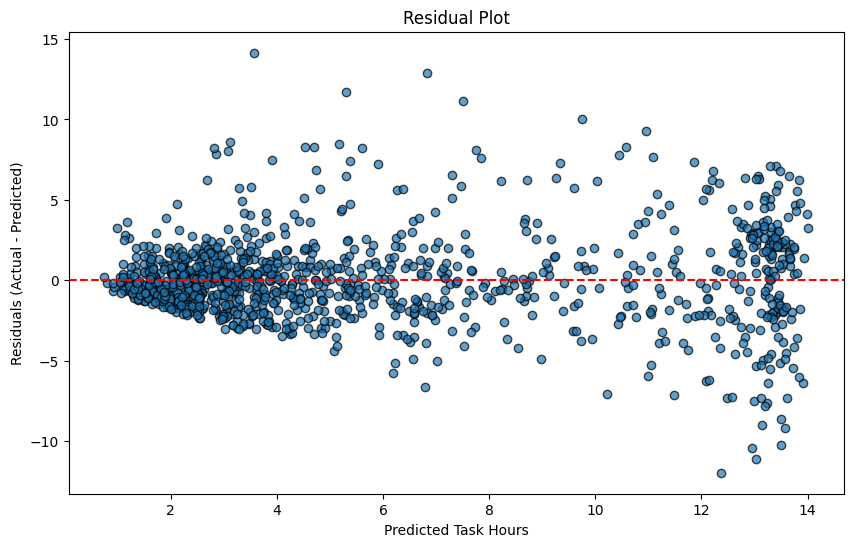

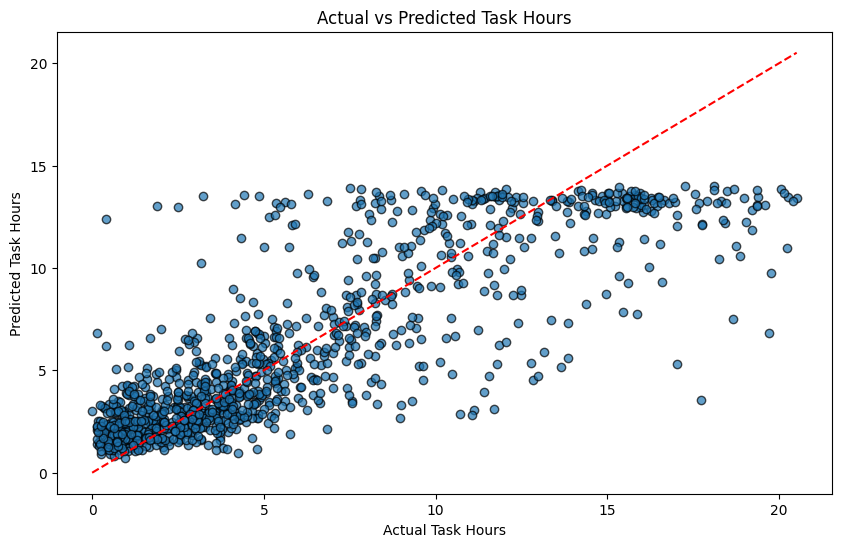

In [ ]:
model = LassoLarsIC(criterion='aic')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Summary
print("\n--- Regression Model Summary ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Selected Alpha (Regularization): {model.alpha_:.4f}")
print(f"Number of Features Used: {np.sum(model.coef_ != 0)} / {X_train.shape[1]}")
print(f"Model Intercept: {model.intercept_:.4f}")


feature_importance = pd.DataFrame({
    'Feature': [f'Embedding {i+1}' for i in range(tn_arr.shape[1])],
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\n--- Feature Importance ---")
print(feature_importance)


residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7, edgecolors='k')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Task Hours')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Task Hours')
plt.xlabel('Actual Task Hours')
plt.ylabel('Predicted Task Hours')
plt.show()


In [ ]:
pip install lightgbm

In [ ]:
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor


estimators = [
    ('lasso', LassoLarsIC()),
    ('lgbm', LGBMRegressor())
]
model = StackingRegressor(estimators=estimators)
model.fit(X_train, y_train)


# Prediction
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)


print("\n--- Regression Model Summary ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")
for name, est in model.named_estimators_.items():
    if hasattr(est, "alpha_"):
        print(f"{name} Alpha: {est.alpha_:.4f}")
    if hasattr(est, "coef_"):
        print(f"{name} - Number of Features Used: {np.sum(est.coef_ != 0)} / {X_train.shape[1]}")
    if hasattr(est, "intercept_"):
        print(f"{name} - Model Intercept: {est.intercept_:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4341, number of used features: 768
[LightGBM] [Info] Start training from score 5.955347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 3472, number of used features: 768
[LightGBM] [Info] Start training from score 6.010886
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 3473, number of used features: 768
[LightGBM] [Info] Sta

In [ ]:
import optuna
from sklearn.linear_model import LassoLarsIC, ElasticNetCV, BayesianRidge, LassoCV, LassoLarsCV, TweedieRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np



def objective(trial):
    # Hyperparameter space
    enet_l1_ratio = trial.suggest_float('elasticnetcv_l1_ratio', 0.1, 0.9)
    tweedie_power = trial.suggest_float('tweedie_power', 1, 2)
    tweedie_alpha = trial.suggest_float('tweedie_alpha', 0.01, 1.0, log=True)
    bayes_alpha_1 = trial.suggest_float('bayesianridge_alpha_1', 1e-6, 1e-1, log=True)
    lasso_cv_alpha = trial.suggest_float('lassocv_alpha', 0.001, 1.0, log=True)
    larsic_criterion = trial.suggest_categorical('lassolarsic_criterion', ['aic', 'bic'])

    # Model parameters
    models = [
        ('lassolarsic', LassoLarsIC(criterion=larsic_criterion)),  # No alpha tuning
        ('elasticnetcv', ElasticNetCV(l1_ratio=enet_l1_ratio)),
        ('tweedie', TweedieRegressor(power=tweedie_power, alpha=tweedie_alpha)),
        ('bayesianridge', BayesianRidge(alpha_1=bayes_alpha_1)),
        ('lassocv', LassoCV(alphas=[lasso_cv_alpha])),
        ('lassolarscv', LassoLarsCV(cv=5))  # No alphas argument, use CV for alpha selection
    ]

    # Ensemble by voting
    voting = VotingRegressor(estimators=models)
    voting.fit(X_train, y_train)
    y_pred = voting.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# Optuna - Maximize R^2
study = optuna.create_study(direction='maximize')  # Maximize R²
study.optimize(objective, n_trials=50)  # Run 50 trials

print("Best Trial:")
print(study.best_trial)
print("Best Hyperparameters:", study.best_trial.params)
best_params = study.best_trial.params

# Evaluate best params
optimized_models = [
    ('lassolarsic', LassoLarsIC(criterion=best_params['lassolarsic_criterion'])),
    ('elasticnetcv', ElasticNetCV(l1_ratio=best_params['elasticnetcv_l1_ratio'])),
    ('tweedie', TweedieRegressor(power=best_params['tweedie_power'], alpha=best_params['tweedie_alpha'])),
    ('bayesianridge', BayesianRidge(alpha_1=best_params['bayesianridge_alpha_1'])),
    ('lassocv', LassoCV(alphas=[best_params['lassocv_alpha']])),
    ('lassolarscv', LassoLarsCV(cv=5))
]

optimized_voting = VotingRegressor(estimators=optimized_models)
optimized_voting.fit(X_train, y_train)
y_pred_optimized = optimized_voting.predict(X_test)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"Optimized Voting Regressor - MSE: {mse_optimized:.4f}")
print(f"Optimized Voting Regressor - R²: {r2_optimized:.4f}")


[I 2025-01-08 07:05:54,209] A new study created in memory with name: no-name-2774907d-f6ee-4810-a851-4cf34e860c9e
[I 2025-01-08 07:06:10,001] Trial 0 finished with value: 0.6956163037639711 and parameters: {'elasticnetcv_l1_ratio': 0.19686477246796708, 'tweedie_power': 1.0925053668139257, 'tweedie_alpha': 0.07560150646174227, 'bayesianridge_alpha_1': 6.851791722549721e-06, 'lassocv_alpha': 0.11783037537092664, 'lassolarsic_criterion': 'bic'}. Best is trial 0 with value: 0.6956163037639711.
[I 2025-01-08 07:06:23,454] Trial 1 finished with value: 0.6955539035828429 and parameters: {'elasticnetcv_l1_ratio': 0.5438076320788224, 'tweedie_power': 1.0167594219874887, 'tweedie_alpha': 0.059013708342479806, 'bayesianridge_alpha_1': 0.0004931234509103318, 'lassocv_alpha': 0.0013816186551339395, 'lassolarsic_criterion': 'bic'}. Best is trial 0 with value: 0.6956163037639711.
[I 2025-01-08 07:06:36,155] Trial 2 finished with value: 0.6949790844380964 and parameters: {'elasticnetcv_l1_ratio': 0.77

Best Trial:
FrozenTrial(number=37, state=1, values=[0.6973898375643423], datetime_start=datetime.datetime(2025, 1, 8, 7, 13, 55, 162307), datetime_complete=datetime.datetime(2025, 1, 8, 7, 14, 9, 226892), params={'elasticnetcv_l1_ratio': 0.782445118866189, 'tweedie_power': 1.718837116781753, 'tweedie_alpha': 0.15462229394888635, 'bayesianridge_alpha_1': 2.7975668895318153e-06, 'lassocv_alpha': 0.007211722997320263, 'lassolarsic_criterion': 'aic'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'elasticnetcv_l1_ratio': FloatDistribution(high=0.9, log=False, low=0.1, step=None), 'tweedie_power': FloatDistribution(high=2.0, log=False, low=1.0, step=None), 'tweedie_alpha': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'bayesianridge_alpha_1': FloatDistribution(high=0.1, log=True, low=1e-06, step=None), 'lassocv_alpha': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'lassolarsic_criterion': CategoricalDistribution(choices=('aic', 'bic'))},

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np


def objective(trial):
    # hyperparameters for XGBoost
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0),
        'objective': 'reg:squarederror',  # Objective for regression
        'eval_metric': 'rmse'  # Pass eval_metric as part of params
    }

    # Train XGBoost
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=False  # Suppresses verbose output during training
    )

    # Prediction and Evaluation
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# Optuna - Maximize R^2
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Run 50 trials

print("Best Trial:")
print(study.best_trial)

print("Best Hyperparameters:", study.best_trial.params)
best_params = study.best_trial.params

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f"Optimized XGBoost - MSE: {mse_final:.4f}")
print(f"Optimized XGBoost - R²: {r2_final:.4f}")


[I 2025-01-08 08:37:57,731] A new study created in memory with name: no-name-3a281980-61e6-4fbc-bbf1-2299f9888296
[I 2025-01-08 08:38:21,643] Trial 0 finished with value: 0.5979307129720275 and parameters: {'max_depth': 8, 'learning_rate': 0.27405150932172356, 'n_estimators': 408, 'min_child_weight': 9.51003938700588, 'gamma': 0.4636808798166635, 'subsample': 0.6404837972375272, 'colsample_bytree': 0.7613822671687474, 'reg_alpha': 0.49036339253793904, 'reg_lambda': 0.030331724612618176}. Best is trial 0 with value: 0.5979307129720275.
[I 2025-01-08 08:39:04,655] Trial 1 finished with value: 0.6635256650734127 and parameters: {'max_depth': 6, 'learning_rate': 0.05107440184703366, 'n_estimators': 543, 'min_child_weight': 2.2181723684981605, 'gamma': 0.25993121205347675, 'subsample': 0.6640458800695553, 'colsample_bytree': 0.8743603143316181, 'reg_alpha': 0.30883937012086216, 'reg_lambda': 0.10447263517135111}. Best is trial 1 with value: 0.6635256650734127.
[I 2025-01-08 08:39:48,834] Tr

Best Trial:
FrozenTrial(number=95, state=1, values=[0.6911533321953485], datetime_start=datetime.datetime(2025, 1, 8, 9, 33, 11, 103673), datetime_complete=datetime.datetime(2025, 1, 8, 9, 33, 33, 669018), params={'max_depth': 3, 'learning_rate': 0.010452671040372386, 'n_estimators': 827, 'min_child_weight': 8.08602067872287, 'gamma': 0.4624761079000392, 'subsample': 0.580343185013487, 'colsample_bytree': 0.8810258622178998, 'reg_alpha': 0.7284749252403504, 'reg_lambda': 0.5664069009686966}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'min_child_weight': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'gamma': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=N

In [ ]:
import optuna
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


def objective(trial):
    hidden_layer_sizes = tuple([trial.suggest_int(f"n_units_{i}", 64, 512) for i in range(trial.suggest_int("n_layers", 1, 3))])
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-3, log=True)
    alpha = trial.suggest_float("alpha", 1e-3, 1e-1, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    batch_size = trial.suggest_int("batch_size", 32, 128)

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=1000,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        activation=activation,
        solver=solver,
        batch_size=batch_size,
        early_stopping=True,
        n_iter_no_change=20,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if np.isnan(y_pred).sum() > 0:
        print("NaNs detected in predictions. Returning -inf to avoid errors.")
        return -np.inf

    return r2_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best Trial:", study.best_trial)
best_params = study.best_trial.params

final_model = MLPRegressor(
    hidden_layer_sizes=tuple([best_params[f"n_units_{i}"] for i in range(best_params['n_layers'])]),
    max_iter=1000,
    learning_rate_init=best_params["learning_rate_init"],
    alpha=best_params["alpha"],
    activation=best_params["activation"],
    solver=best_params["solver"],
    batch_size=best_params["batch_size"],
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)

mse_final = mean_squared_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f"Optimized MLP - MSE: {mse_final:.4f}")
print(f"Optimized MLP - R²: {r2_final:.4f}")


[I 2025-01-08 11:23:22,952] A new study created in memory with name: no-name-ee1ac174-a886-4ebf-a66f-5dac06cf4a19
[I 2025-01-08 11:23:33,327] Trial 0 finished with value: 0.6948437916775428 and parameters: {'n_layers': 1, 'n_units_0': 73, 'learning_rate_init': 7.499468052738151e-05, 'alpha': 0.011700761684492087, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 59}. Best is trial 0 with value: 0.6948437916775428.
[I 2025-01-08 11:24:00,421] Trial 1 finished with value: 0.6962827408924859 and parameters: {'n_layers': 1, 'n_units_0': 307, 'learning_rate_init': 0.0003462822022261528, 'alpha': 0.004167890695695698, 'activation': 'relu', 'solver': 'adam', 'batch_size': 97}. Best is trial 1 with value: 0.6962827408924859.
[I 2025-01-08 11:25:52,540] Trial 2 finished with value: 0.6920281170033654 and parameters: {'n_layers': 3, 'n_units_0': 380, 'n_units_1': 269, 'n_units_2': 482, 'learning_rate_init': 1.7896086900349024e-05, 'alpha': 0.011092910878338153, 'activation': 'tanh', 'solver'

Best Trial: FrozenTrial(number=38, state=1, values=[0.6989567687402705], datetime_start=datetime.datetime(2025, 1, 8, 11, 44, 26, 938112), datetime_complete=datetime.datetime(2025, 1, 8, 11, 45, 40, 184255), params={'n_layers': 3, 'n_units_0': 416, 'n_units_1': 255, 'n_units_2': 89, 'learning_rate_init': 0.00011055829270347837, 'alpha': 0.0031290467698846637, 'activation': 'relu', 'solver': 'sgd', 'batch_size': 114}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_layers': IntDistribution(high=3, log=False, low=1, step=1), 'n_units_0': IntDistribution(high=512, log=False, low=64, step=1), 'n_units_1': IntDistribution(high=512, log=False, low=64, step=1), 'n_units_2': IntDistribution(high=512, log=False, low=64, step=1), 'learning_rate_init': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'alpha': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'solver': CategoricalDis

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Numpy -> PyTorch Tensors -> GPU
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Bi-LSTM Model
class BiLSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(BiLSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 1)  # *2 for bidirectional

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(1))  # Add sequence dimension
        out = self.dropout(out[:, -1, :])  # Last hidden state with dropout
        out = self.fc(out)
        return out

# Optuna
def objective(trial):
    # Bi-LSTM Hyperparameter Space
    hidden_dim = trial.suggest_int("hidden_dim", 32, 512)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 64)
    epochs = 50

    # Model and move to device
    model = BiLSTMRegressor(input_dim=768, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training
    model.train()
    for epoch in range(epochs):
        permutation = torch.randperm(X_train_tensor.size(0))
        for i in range(0, X_train_tensor.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).squeeze().cpu().numpy()

    r2 = r2_score(y_test, y_pred)
    if np.isnan(r2):
        return -np.inf
    return r2

# Optuna - Maximize R^2
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best Trial
print("Best Trial:", study.best_trial)
best_params = study.best_trial.params

# Evaluation with best params
best_model = BiLSTMRegressor(
    input_dim=768,
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.MSELoss()

# Final Training
epochs = 100
for epoch in range(epochs):
    permutation = torch.randperm(X_train_tensor.size(0))
    for i in range(0, X_train_tensor.size(0), best_params['batch_size']):
        indices = permutation[i:i + best_params['batch_size']]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = best_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# Evaluation Final Model
best_model.eval()
with torch.no_grad():
    y_pred_final = best_model(X_test_tensor).squeeze().cpu().numpy()

mse_final = mean_squared_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f"Bi-LSTM Optimized (CUDA) - MSE: {mse_final:.4f}")
print(f"Bi-LSTM Optimized (CUDA) - R²: {r2_final:.4f}")

[I 2025-01-08 12:02:08,115] A new study created in memory with name: no-name-8fa6c2f6-d347-46d0-85d0-5f6539b9c902


Using device: cuda


[I 2025-01-08 12:04:59,765] Trial 0 finished with value: 0.6252545082248282 and parameters: {'hidden_dim': 436, 'num_layers': 3, 'dropout': 0.2611000809427132, 'learning_rate': 0.00013004860142568013, 'batch_size': 19}. Best is trial 0 with value: 0.6252545082248282.
[I 2025-01-08 12:05:59,043] Trial 1 finished with value: 0.6255657309700291 and parameters: {'hidden_dim': 369, 'num_layers': 2, 'dropout': 0.19286266797319557, 'learning_rate': 0.00026893520065865895, 'batch_size': 33}. Best is trial 1 with value: 0.6255657309700291.
[I 2025-01-08 12:07:36,003] Trial 2 finished with value: 0.660235922908917 and parameters: {'hidden_dim': 480, 'num_layers': 2, 'dropout': 0.23644747420647946, 'learning_rate': 0.007150432581211484, 'batch_size': 27}. Best is trial 2 with value: 0.660235922908917.
[I 2025-01-08 12:09:23,893] Trial 3 finished with value: 0.6597784260474722 and parameters: {'hidden_dim': 491, 'num_layers': 3, 'dropout': 0.2456134074729338, 'learning_rate': 0.0027090205168812903

Best Trial: FrozenTrial(number=44, state=1, values=[0.6976025383968112], datetime_start=datetime.datetime(2025, 1, 8, 12, 34, 55, 334460), datetime_complete=datetime.datetime(2025, 1, 8, 12, 36, 22, 454197), params={'hidden_dim': 474, 'num_layers': 1, 'dropout': 0.42619571351314206, 'learning_rate': 0.0019029723053228772, 'batch_size': 16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_dim': IntDistribution(high=512, log=False, low=32, step=1), 'num_layers': IntDistribution(high=3, log=False, low=1, step=1), 'dropout': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'learning_rate': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'batch_size': IntDistribution(high=64, log=False, low=16, step=1)}, trial_id=44, value=None)
Bi-LSTM Optimized (CUDA) - MSE: 7.9241
Bi-LSTM Optimized (CUDA) - R²: 0.6932
